<p>
    <img src="https://s3.amazonaws.com/iotanalytics-templates/Logo.png" style="float:left;">
    <h1 style="color:#1A5276;padding-left:115px;padding-bottom:0px;font-size:28px;">AWS IoT Analytics | Solar Panel Output Forecasting</h1>
</p>
<p style="color:#1A5276;padding-left:90px;padding-top:0px;position:relative;font-style:italic;font-size:18px">
Application of piecewise, seasonal, linear time series models with trend to predicting the output of solar panels.   </p>

For businesses and operations alike, forecasting is a critical decision support tool.  In the energy sector, forecasting power generation and power utilization allows utilities and corporations to match power supply with demand, reducing disruptions and the cost of distributed power storage and ensuring an efficient energy market. In regard to renewable energy supply and almost all energy demand, there are cyclical patterns driven by repeating human patterns of the work week and the seasonal variation of weather patterns. Such business, human consumption and weather cycles complicate forecasting with IoT output in such industries. 

In this Notebook Template, we use Prophet, an open source forecasting library for time series data with built-in cyclical behavior adjustments, to forecast the power output of a solar panel. Using the parameters available in Prophet, this template can be easily extended to forecasting of individual and fleets of devices, as well as IoT monitored process outputs.   

## Set-up: Import Required Notebook Libraries

In [1]:
import pandas as pd
import numpy as np
import sys

In [2]:
#This notebook uses fbprophet library, so first check if library exists otherwise install it.

try:
    import fbprophet
except:
    !conda install -c conda-forge --yes --prefix {sys.prefix} fbprophet

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.4.10
  latest version: 4.5.11

Please update conda by running

    $ conda update -n base conda



## Package Plan ##

  environment location: /home/ec2-user/anaconda3/envs/python3

  added / updated specs: 
    - fbprophet


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    fbprophet-0.3.post2        |           py36_0         4.5 MB  conda-forge
    numpy-1.14.3               |   py36h28100ab_1          41 KB
    certifi-2018.8.24          |           py36_1         139 KB  conda-forge
    openssl-1.0.2p             |       h470a237_0         3.5 MB  conda-forge
    ca-certificates-2018.8.24  |       ha4d7672_0         136 KB  conda-forge
    pystan-2.17.1.0            |   py36hf8a1672_1        30.6 MB  conda-forge
    ------------------------------------------------------------
           

In [3]:
from fbprophet import Prophet

In [4]:
import matplotlib.pyplot as plt

%matplotlib inline
 
plt.rcParams['figure.figsize']=(20,10)
plt.style.use('ggplot')

## Background: Problem Description and Approach

Prophet implements a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly and weekly seasonality, plus holidays. It works best with daily periodicity data with at least one year of historical data. Prophet is robust in regard to missing data, shifts in the trend, and large outliers.

Prophet is optimized for those business forecast tasks which typically share the following characteristics with IoT data:

* a reasonable number of missing observations or large outliers
* historical trend changes, for instance due to product launches or logging changes
* trends that are non-linear growth curves, where a trend hits a natural limit or saturates
* hourly, daily, or weekly observations with at least a few months (preferably a year) of history
* strong multiple ���human-scale��� seasonalities: day of week and time of year
* important holidays that occur at irregular intervals that are known in advance (e.g. the Super Bowl)


<h1 style="color:#20B3CD;font-size:20px;float:left">Step 1  |  Loading Data </h1> <div style="float:right;height:7px;background-color:#20B3CD;margin-top:30px;width:70%"></div>

### Dataset Description

Forecasting is highly sensitive to features and noise in the training Data Set. This has meant that most forecasting is a highly manual process with data scientists spending many iterations inspecting and removing spurious features from data. Time series data from IoT devices which are measuring the physical world are particularly challenging. For this reason, we've chosen to look at the sum of daily power produced by a solar panel over 2 years, rather than the shorter period of minute by minute production which includes diurnal variations that we aren't interested in. Our sample Data Set is solar panel power production data, consisting simply of the date and the watts produced. The panel is located near Seattle, WA and rated for a peak of around 35kW.    

<img src="https://s3.amazonaws.com/iotanalytics-templates/Logo.png" style="float:left;height:20px;"></img><b style="color:#1A5276;padding-left:5px;">PRODUCTION NOTE</b> To reduce noise in the sample Solar Panel Data Set, the AWS IoT Analytics Pipeline used to preprocess the raw data coming from the device's raw data channel included a custom Lambda Activity that identified and removed outliers. This is a common pattern in forecasting which is sensitive to large volatility in the training data.

In order to run the algorithm on your data, set the `use_sample_dataset` variable to `False` and specify the names of the dataset, time and value columns (In order to need to perform get_dataset_content, you need to grant iot analytics corresponding IAM permission):

In [5]:
use_sample_dataset = True
dataset = "all_data"
time_col = 'timestamp'
value_col = 'temperature'

Next, let us load data either from the IoT Analytics dataset specified in the `dataset` variable or the sample Solar Panel Data Set (if `use_sample_dataset` is True or the specified IoT Analytics dataset is invalid).

In [6]:
import boto3

# create IoT Analytics client
client = boto3.client('iotanalytics')

try: # read dataset contents into a data frame
    if use_sample_dataset:
        raise Exception('Using sample data since use_sample_dataset is True')
    dataset_url = client.get_dataset_content(datasetName = dataset)['entries'][0]['dataURI']
    data_df = pd.read_csv(dataset_url, index_col=time_col, parse_dates=True).sort_index()
    if data_df.empty:
        raise Exception('No data found')
except: # use sample dataset in case of any error
    time_col, value_col = 'Date', 'Data'
    data_df = pd.read_csv('https://s3.amazonaws.com/iotanalytics-templates/data/solar_normalized.csv', index_col=time_col, parse_dates=True).sort_index()
    from IPython.display import display, Markdown
    import traceback
    display(Markdown('# <span style="color:black">{}</span>\n{}'.format('Using the sample dataset', traceback.format_exc())))
    
display(data_df[:5]) # display first 5 records of the Data Set

INFO:botocore.vendored.requests.packages.urllib3.connectionpool:Starting new HTTP connection (1): 169.254.169.254
INFO:botocore.vendored.requests.packages.urllib3.connectionpool:Starting new HTTP connection (1): 169.254.169.254


# <span style="color:black">Using the sample dataset</span>
Traceback (most recent call last):
  File "<ipython-input-6-f78ac86ec6f8>", line 8, in <module>
    raise Exception('Using sample data since use_sample_dataset is True')
Exception: Using sample data since use_sample_dataset is True


,Data
Date,
2015-07-06,30286
2015-07-07,32675
2015-07-08,32014
2015-07-09,32715
2015-07-10,32836


Our sample Data Set starts in July of 2015 with 30-32kW produced per day (see above) and includes data up to October 2017, the month before this Template was published, where production has dropped and the range has narrowed to 26-27kW per day power production.

In [7]:
data_df.tail() #display last 5 records of the Data Set

,Data
Date,
2017-10-07,26729
2017-10-08,27006
2017-10-09,26890
2017-10-10,26642
2017-10-11,26265


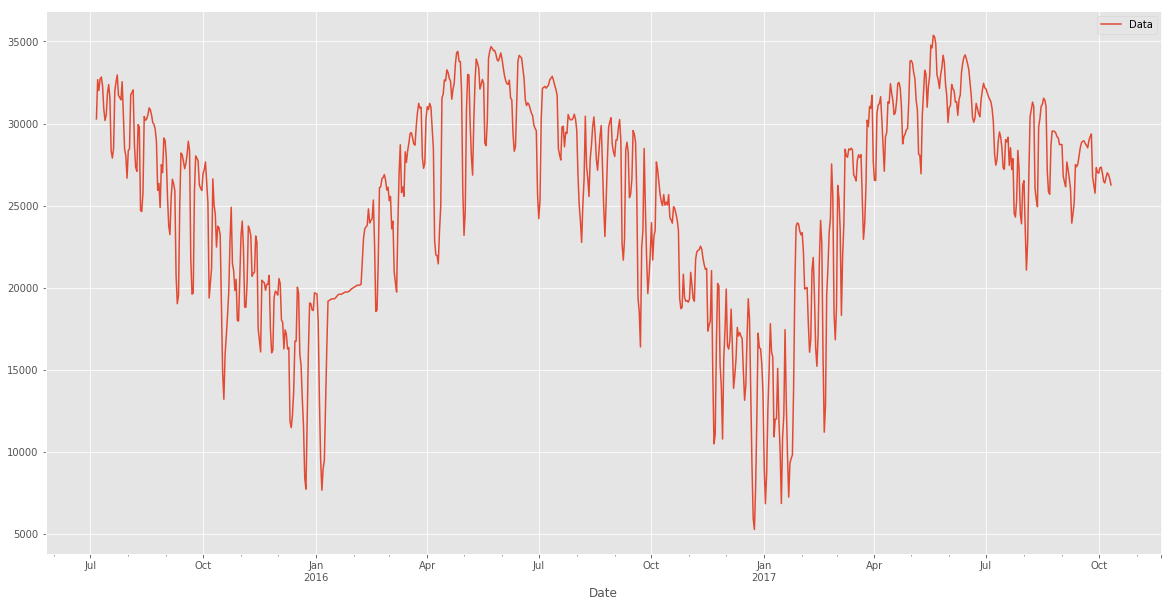

In [8]:
data_df.plot() #Plot Data Set

With our sample Data Set, even after normalization in the AWS IoT Analytics Pipeline there is large variability in production output. This is due to rainy and overcast days. On the occasional snowy day, we usually see rain as well so snow build up doesn't block a full days production.  

Let's see how our forecasting does with this data.

<h1 style="color:#20B3CD;font-size:20px;float:left">Step 2  |  Running Prophet Algorithm</h1> <div style="float:right;height:7px;background-color:#20B3CD;margin-top:30px;width:70%"></div>

As mentioned in BACKGROUND, Prophet needs at least a year of time series training data to accurately account for  periodicity in the Data Set. As input, Prophet takes a DataFrame with two columns, the date or timestamp (ds) and the target value to forecast (y) which in our sample Data Set is the power output of the solar panel. Prophet further requires that we perform a log transformation of our target values (y) if the target is not already on log scale.

In [9]:
# restructure the DataFrame for Prophet ingest by renaming columns and taking the log of target values
df = data_df.reset_index().rename(columns={'Date':'ds', 'Data':'y'})
df['y'] = np.log(df['y'])

Here we instantiate prophet and fit our data. This includes our future DataFrame or the period in days for which we want Prophet to provide a forecast.

In [10]:
model = Prophet()
model.fit(df);
future = model.make_future_dataframe(periods=60) #forecasting for 60 days
forecast = model.predict(future)

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


<h1 style="color:#20B3CD;font-size:20px;float:left">Step 3  |  Evaluating Forecasts through Visualization</h1> <div style="float:right;height:7px;background-color:#20B3CD;margin-top:30px;width:70%"></div>

We now have a Prophet forcast for our Data Set plus the forecasting period, originally set to 60 days, for future values of our Data Set. Below we plot that forecast to see how well the forecast behaves.

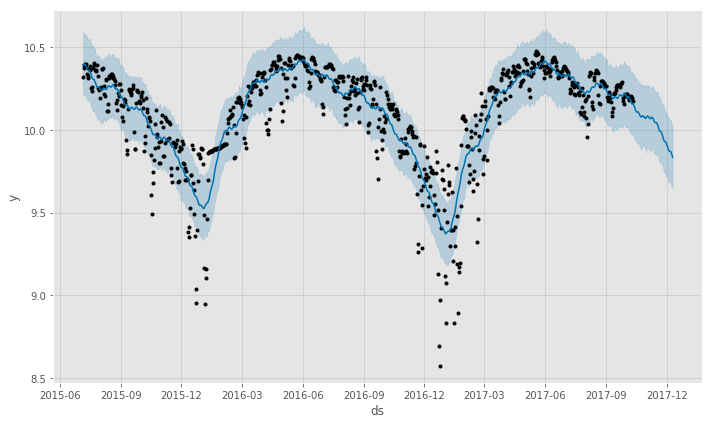

In [11]:
figure=model.plot(forecast)

### Evaluating the Forecast

With the data that we have, it is hard to see how good/bad the forecast (blue line) is compared to the actual data (black dots).  Let's take a look at the last 800 days (about 2 years) of forecast vs actual without looking at the future forecast. In this case, we are just interested in getting a visual of the error between actual vs forecast. 

Prophet's predict method assigns a predicted value for each date in the future which it names yhat. If you pass in historical dates, Prophet provides an in-sample fit. The forecast is returned as a new dataframe that includes a column yhat for the predicted values with the forecast, as well as columns for components and uncertainty intervals. yhat_upper represents the upper bounds of the predicted data point, while yhat_lower represents the lowest expected value.

In [12]:
# extend the forecasting view to two years
two_years = forecast.set_index('ds').join(data_df)
two_years = two_years[['Data', 'yhat', 'yhat_upper', 'yhat_lower' ]].dropna().tail(800)
two_years['yhat']=np.exp(two_years.yhat)
two_years['yhat_upper']=np.exp(two_years.yhat_upper)
two_years['yhat_lower']=np.exp(two_years.yhat_lower)

In [13]:
two_years.tail()

,Data,yhat,yhat_upper,yhat_lower
ds,,,,
2017-10-07,26729.0,26469.721209,31702.715977,21588.956591
2017-10-08,27006.0,26120.946785,31245.582378,21779.542618
2017-10-09,26890.0,25883.608856,31347.927066,21399.318798
2017-10-10,26642.0,25749.811384,31285.605365,21459.817785
2017-10-11,26265.0,25750.420263,30562.860065,21625.890029


Now let's plot our actual Data Set (red) versus the Prophet forcast (yhat in blue) to see if Prophet is in need capturing the broader cycles in our data, as well as fitting the day to day output trends.   

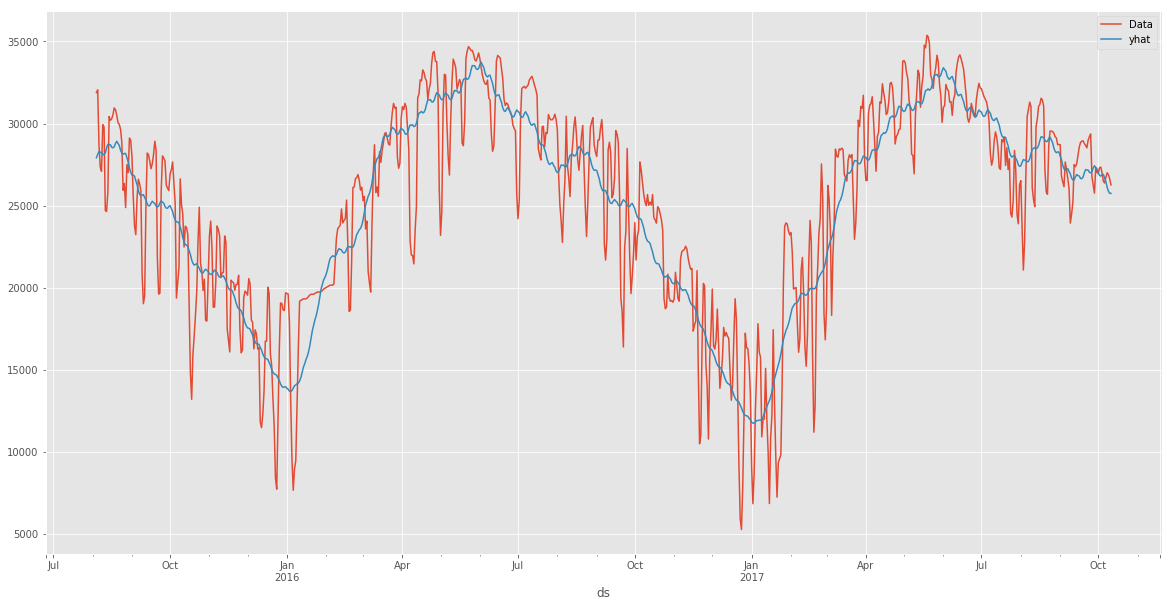

In [14]:
two_years[['Data', 'yhat']].plot()

You can see from the above chart, our forecast follows the trend quite well but doesn't seem to catch the 'volatility' of the solar production day to day. This is desired behavior as we do not want the algorithm to overfit the training data.


### Improving our Forecast Handling of Day to Day Output Volatility

Another way to look at the usefulness of this forecast is to plot the upper and lower confidence bands of the forecast against the actuals. You can do that by plotting yhat_upper and yhat_lower.  

Text(0.5,0,'Date')

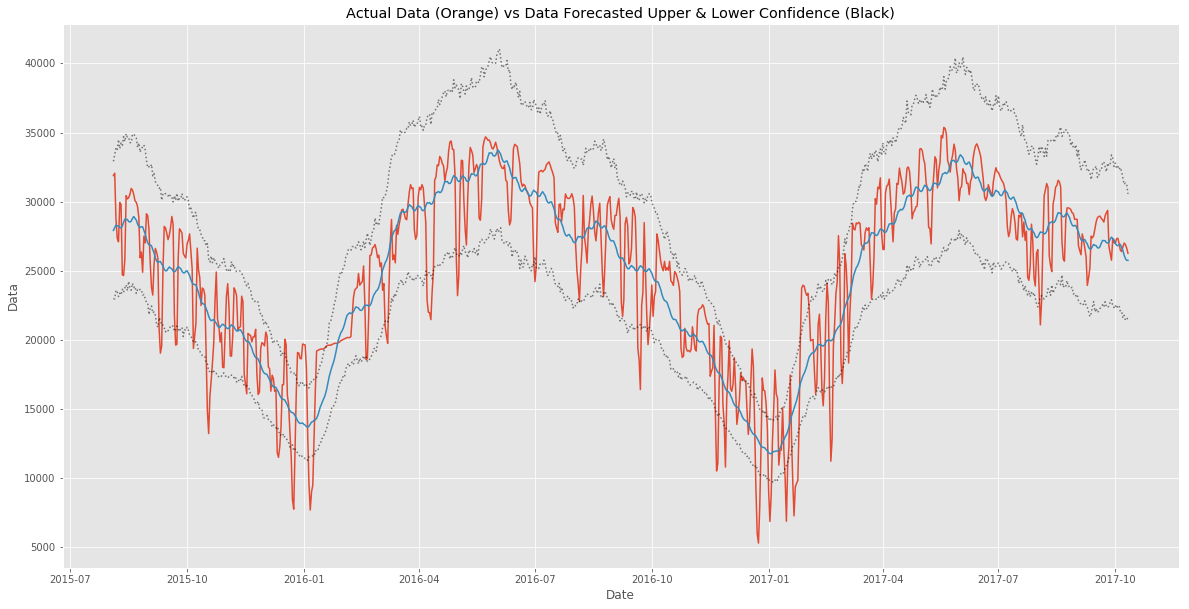

In [15]:
# plot two years of data and the forecasted data with upper and lower bounds of the forcast
fig, ax1 = plt.subplots()
ax1.plot(two_years.Data)
ax1.plot(two_years.yhat)
ax1.plot(two_years.yhat_upper, color='black',  linestyle=':', alpha=0.5)
ax1.plot(two_years.yhat_lower, color='black',  linestyle=':', alpha=0.5)

# configure chart with axis labels
ax1.set_title('Actual Data (Orange) vs Data Forecasted Upper & Lower Confidence (Black)')
ax1.set_ylabel('Data')
ax1.set_xlabel('Date')


In the above chart, we can see the forecast (in blue) vs the actuals (in orange) with the upper and lower confidence bands in gray.  



<h1 style="color:#20B3CD;font-size:20px;float:left">Step 4  |  Interpreting Results</h1> <div style="float:right;height:7px;background-color:#20B3CD;margin-top:30px;width:70%"></div>

Let's go back and look at the actual predicted future forecast to see if it might tell us anything different than the forecast vs the actual data.

In [16]:
# retrieve the full Prophet returned DataFrame
full_df = forecast.set_index('ds').join(data_df)
full_df['yhat']=np.exp(full_df['yhat'])

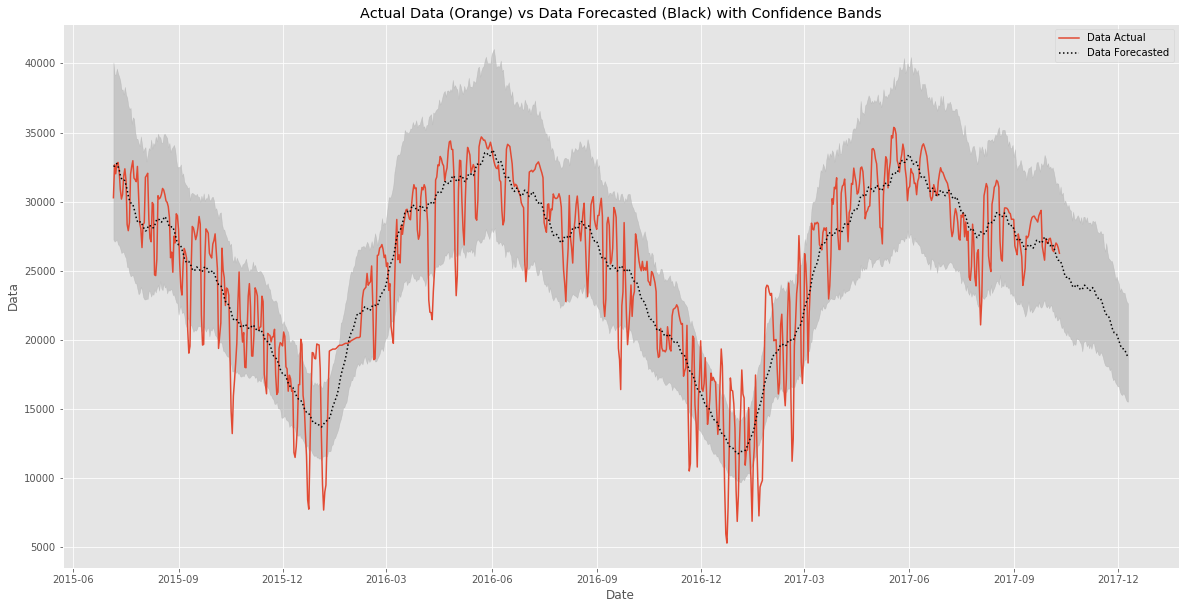

In [17]:
# plot two years of data and the forecasted data with upper and lower bounds of the forcast
fig, ax1 = plt.subplots()
ax1.plot(full_df.Data)
ax1.plot(full_df.yhat, color='black', linestyle=':')
ax1.fill_between(full_df.index, np.exp(full_df['yhat_upper']), np.exp(full_df['yhat_lower']), alpha=0.5, color='darkgray')

ax1.set_title('Actual Data (Orange) vs Data Forecasted (Black) with Confidence Bands')
ax1.set_ylabel('Data')
ax1.set_xlabel('Date')

L=ax1.legend() #get the legend
L.get_texts()[0].set_text('Data Actual') #change the legend text for 1st plot
L.get_texts()[1].set_text('Data Forecasted') #change the legend text for 2nd plot

This chart is a bit easier to understand vs the default prophet chart. We can see throughout the history of the actuals vs forecast that prophet does an a good job of forecasting seasonal variation, and captures that some periods of the seasonal cycle (summer and spring in our example) may have higher volatility than other periods in the cycle (the more reliably cloudy winter months).

In this Notebook, we've seen that Prophet does a good job with time series forecasting of Data Sets that have underlying periodicity. Although the forecast on our Solar Panel Output Data Set will not be useful in a day-to-day prediction of solar panel output, it is useful to determine longer scale output forecasts such as those required for subsystem sizing and capacity planning. For Solar Panel data this is not a surprising result, as day-to-day solar panel output is highly dependent on the weather and not taken into account here. 

Prophet, with its time series support, built-in resilience to missing data and ability to handle periodicity, is a good fit for many IoT forecasting scenarios.

<div style="height:60px;"><div style="height:7px;background-color:#20B3CD;width:100%;margin-top:20px;position:relative;"><img src="https://s3.amazonaws.com/iotanalytics-templates/Logo.png" style="height:50px;width:50px;margin-top:-20px;position:absolute;margin-left:42%;"></div></div>